## QUESTION 1

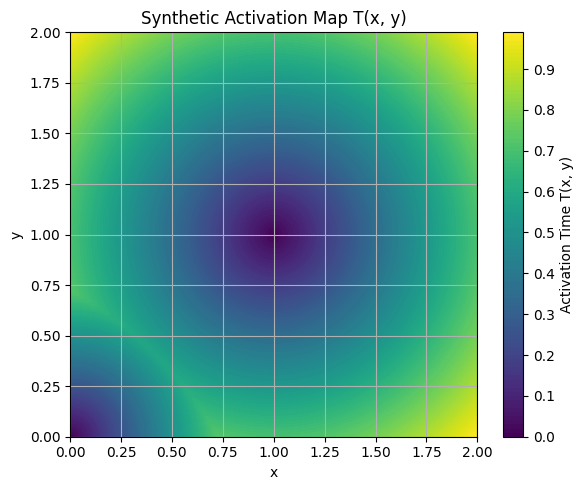

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Create a grid
x = np.linspace(0, 2, 200)
y = np.linspace(0, 2, 200)
X, Y = np.meshgrid(x, y)

# Compute T(x, y)
T1 = np.sqrt(X**2 + Y**2)
T2 = 0.7 * np.sqrt((X - 1)**2 + (Y - 1)**2)
T = np.minimum(T1, T2)

# Plot
plt.figure(figsize=(6, 5))
contour = plt.contourf(X, Y, T, levels=100, cmap='viridis')
plt.colorbar(contour, label='Activation Time T(x, y)')
plt.title('Synthetic Activation Map T(x, y)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.tight_layout()
plt.show()


## Define and Visualize Conduction Velocity
𝑉
(
𝑥
,
𝑦
)
V(x,y)

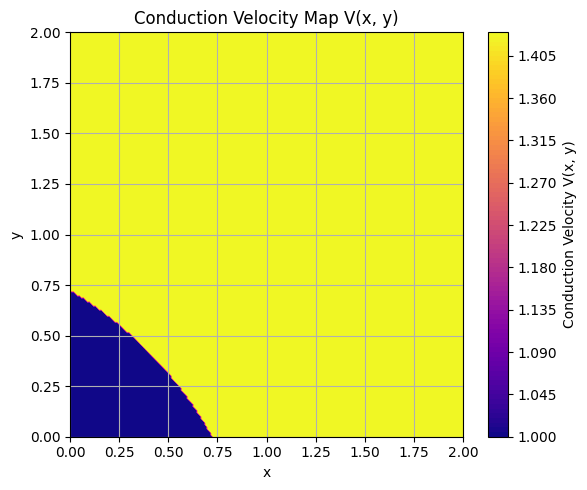

In [2]:
# Compute V(x, y) based on condition
mask = np.sqrt(X**2 + Y**2) < 0.7 * np.sqrt((X - 1)**2 + (Y - 1)**2)
V = np.where(mask, 1.0, 1.0 / 0.7)

# Plot
plt.figure(figsize=(6, 5))
contour = plt.contourf(X, Y, V, levels=100, cmap='plasma')
plt.colorbar(contour, label='Conduction Velocity V(x, y)')
plt.title('Conduction Velocity Map V(x, y)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.tight_layout()
plt.show()


In [4]:
!pip install pyDOE


  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=668b434f6843058e257d86e53b8f13840d32482195af61ddac7e82787210ab34
  Stored in directory: /root/.cache/pip/wheels/84/20/8c/8bd43ba42b0b6d39ace1219d6da1576e0dac81b12265c4762e
Successfully built pyDOE


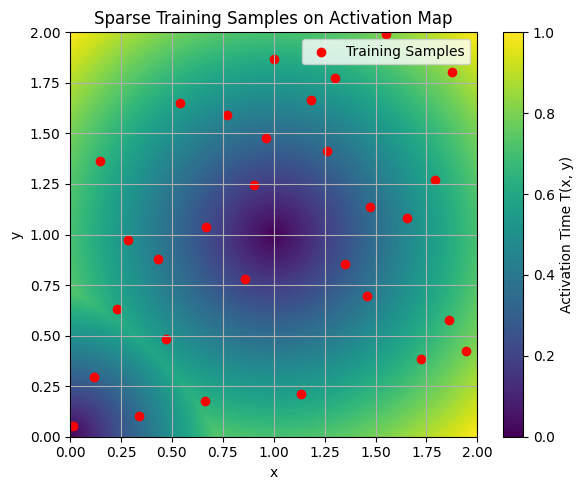

In [5]:
from pyDOE import lhs  # Latin Hypercube Sampling

# Number of samples
n_samples = 30

# Latin Hypercube Sampling in 2D
samples = lhs(2, samples=n_samples)
samples = 2 * samples  # scale from [0, 1] to [0, 2]

# Evaluate T(x, y) at sampled points
x_samples = samples[:, 0]
y_samples = samples[:, 1]
T1_samples = np.sqrt(x_samples**2 + y_samples**2)
T2_samples = 0.7 * np.sqrt((x_samples - 1)**2 + (y_samples - 1)**2)
T_samples = np.minimum(T1_samples, T2_samples)

# Visualize sampled points on activation map
plt.figure(figsize=(6, 5))
plt.contourf(X, Y, T, levels=100, cmap='viridis')
plt.scatter(x_samples, y_samples, color='red', label='Training Samples')
plt.colorbar(label='Activation Time T(x, y)')
plt.title('Sparse Training Samples on Activation Map')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## PART B: Build a feedforward neural network to approximate
𝑇
(
𝑥
,
𝑦
)
T(x,y)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

# Convert training data to tensors
x_train = torch.tensor(x_samples, dtype=torch.float32).view(-1, 1)
y_train = torch.tensor(y_samples, dtype=torch.float32).view(-1, 1)
xy_train = torch.cat([x_train, y_train], dim=1)
T_train = torch.tensor(T_samples, dtype=torch.float32).view(-1, 1)

# Define the model
class FeedforwardNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

model_data = FeedforwardNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model_data.parameters(), lr=0.01)

# Training loop
epochs = 1000
for epoch in range(epochs):
    model_data.train()
    optimizer.zero_grad()
    output = model_data(xy_train)
    loss = criterion(output, T_train)
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")


Epoch 0, Loss: 0.109845
Epoch 200, Loss: 0.002138
Epoch 400, Loss: 0.000206
Epoch 600, Loss: 0.000125
Epoch 800, Loss: 0.000077


## Physics-Informed Neural Network (Model 2 – PINN)

In [7]:
# Reuse the same architecture
model_pinn = FeedforwardNN()
optimizer_pinn = optim.Adam(model_pinn.parameters(), lr=0.01)

# Turn samples into tensors with gradients
xy_train_pinn = xy_train.clone().detach().requires_grad_(True)

# Define conduction velocity at sampled points
V_vals = np.where(
    np.sqrt(x_samples**2 + y_samples**2) < 0.7 * np.sqrt((x_samples - 1)**2 + (y_samples - 1)**2),
    1.0,
    1.0 / 0.7
)
V_tensor = torch.tensor(V_vals, dtype=torch.float32).view(-1, 1)

# Training loop
epochs = 1000
for epoch in range(epochs):
    model_pinn.train()
    optimizer_pinn.zero_grad()

    # Predict T
    T_pred = model_pinn(xy_train_pinn)

    # Compute gradients ∇T w.r.t x and y
    grad_T = torch.autograd.grad(
        outputs=T_pred,
        inputs=xy_train_pinn,
        grad_outputs=torch.ones_like(T_pred),
        create_graph=True,
        retain_graph=True
    )[0]

    grad_norm = torch.norm(grad_T, dim=1, keepdim=True)  # ||∇T||

    # Eikonal residual loss
    residual = V_tensor * grad_norm - 1.0
    loss_pinn = torch.mean(residual**2)

    loss_pinn.backward()
    optimizer_pinn.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch}, PINN Loss: {loss_pinn.item():.6f}")


Epoch 0, PINN Loss: 0.881789
Epoch 200, PINN Loss: 0.000643
Epoch 400, PINN Loss: 0.000012
Epoch 600, PINN Loss: 0.000004
Epoch 800, PINN Loss: 0.000002


In [8]:
# Reuse the same architecture
model_pinn = FeedforwardNN()
optimizer_pinn = optim.Adam(model_pinn.parameters(), lr=0.01)

# Turn samples into tensors with gradients
xy_train_pinn = xy_train.clone().detach().requires_grad_(True)

# Define conduction velocity at sampled points
V_vals = np.where(
    np.sqrt(x_samples**2 + y_samples**2) < 0.7 * np.sqrt((x_samples - 1)**2 + (y_samples - 1)**2),
    1.0,
    1.0 / 0.7
)
V_tensor = torch.tensor(V_vals, dtype=torch.float32).view(-1, 1)

# Training loop
epochs = 1000
for epoch in range(epochs):
    model_pinn.train()
    optimizer_pinn.zero_grad()

    # Predict T
    T_pred = model_pinn(xy_train_pinn)

    # Compute gradients ∇T w.r.t x and y
    grad_T = torch.autograd.grad(
        outputs=T_pred,
        inputs=xy_train_pinn,
        grad_outputs=torch.ones_like(T_pred),
        create_graph=True,
        retain_graph=True
    )[0]

    grad_norm = torch.norm(grad_T, dim=1, keepdim=True)  # ||∇T||

    # Eikonal residual loss
    residual = V_tensor * grad_norm - 1.0
    loss_pinn = torch.mean(residual**2)

    loss_pinn.backward()
    optimizer_pinn.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch}, PINN Loss: {loss_pinn.item():.6f}")


Epoch 0, PINN Loss: 0.898240
Epoch 200, PINN Loss: 0.000142
Epoch 400, PINN Loss: 0.000039
Epoch 600, PINN Loss: 0.000017
Epoch 800, PINN Loss: 0.000010


In [36]:
# Rebuild the grid (same as before)
x = np.linspace(0, 2, 200)
y = np.linspace(0, 2, 200)
X, Y = np.meshgrid(x, y)  # Both X and Y now shape (200, 200)

# Flatten them properly
x_flat = X.flatten()  # (40000,)
y_flat = Y.flatten()  # (40000,)

# Stack into shape (40000, 2)
xy_grid_np = np.column_stack((x_flat, y_flat))

# Convert to tensor
xy_grid_grad = torch.tensor(xy_grid_np, dtype=torch.float32, requires_grad=True)


In [37]:
# Predict T using the PINN
T_pred_grid = model_pinn(xy_grid_grad)

# Compute ∇T using autograd
grad_T_grid = torch.autograd.grad(
    outputs=T_pred_grid,
    inputs=xy_grid_grad,
    grad_outputs=torch.ones_like(T_pred_grid),
    create_graph=True,
    retain_graph=True
)[0]

# ∥∇T∥
grad_norm_grid = torch.norm(grad_T_grid, dim=1)
grad_norm_grid_2d = grad_norm_grid.detach().numpy().reshape(X.shape)


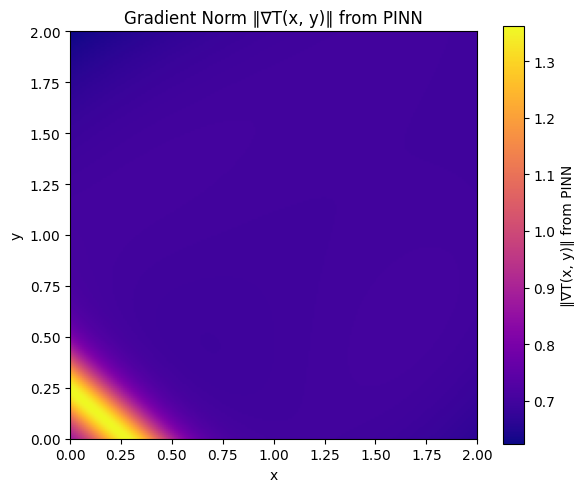

In [39]:
plt.figure(figsize=(6, 5))
plt.imshow(grad_norm_grid_2d, origin='lower', extent=[0, 2, 0, 2], cmap='plasma')
plt.colorbar(label='∥∇T(x, y)∥ from PINN')
plt.title("Gradient Norm ∥∇T(x, y)∥ from PINN")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(False)
plt.tight_layout()
plt.show()


In [38]:
print("Gradient Norm Summary:")
print("Min:", np.min(grad_norm_grid_2d))
print("Max:", np.max(grad_norm_grid_2d))
print("Mean:", np.mean(grad_norm_grid_2d))
print("Std:", np.std(grad_norm_grid_2d))


Gradient Norm Summary:
Min: 0.62422854
Max: 1.3613901
Mean: 0.71372736
Std: 0.08259828


##: Grid Predictions + Visualization

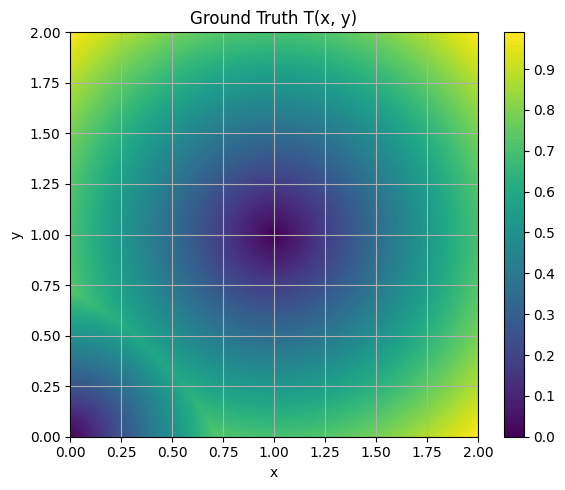

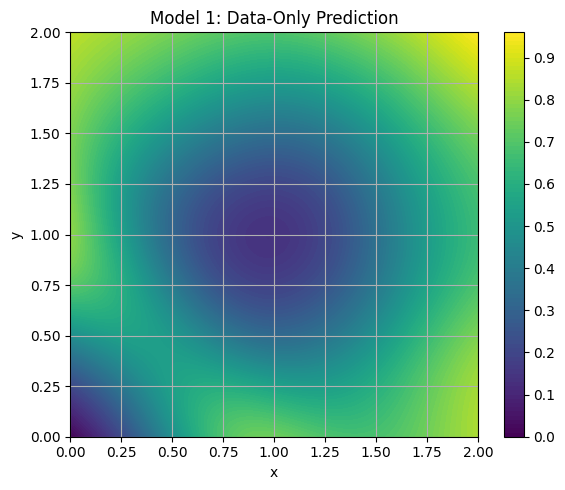

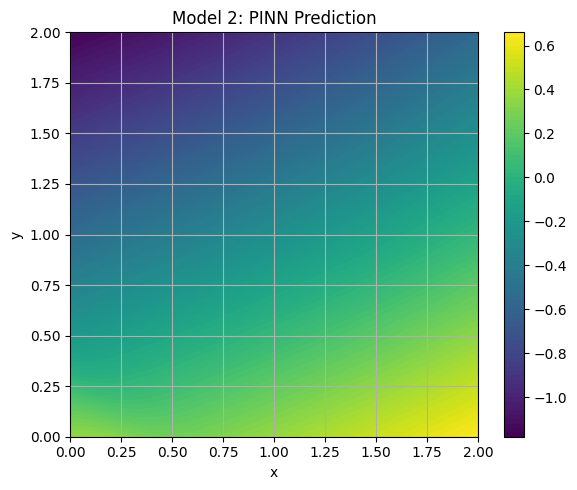

In [9]:
# Prepare input grid
X_flat = X.flatten()
Y_flat = Y.flatten()
xy_grid = torch.tensor(np.vstack((X_flat, Y_flat)).T, dtype=torch.float32)

# Ground truth
T1_grid = np.sqrt(X_flat**2 + Y_flat**2)
T2_grid = 0.7 * np.sqrt((X_flat - 1)**2 + (Y_flat - 1)**2)
T_true = np.minimum(T1_grid, T2_grid).reshape(X.shape)

# Model predictions
model_data.eval()
model_pinn.eval()
with torch.no_grad():
    T_data_pred = model_data(xy_grid).cpu().numpy().reshape(X.shape)
    T_pinn_pred = model_pinn(xy_grid).cpu().numpy().reshape(X.shape)

# Plotting function
def plot_comparison(true, pred, title):
    plt.figure(figsize=(6, 5))
    contour = plt.contourf(X, Y, pred, levels=100, cmap='viridis')
    plt.colorbar(contour)
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Ground truth and predictions
plot_comparison(T_true, T_true, "Ground Truth T(x, y)")
plot_comparison(T_true, T_data_pred, "Model 1: Data-Only Prediction")
plot_comparison(T_true, T_pinn_pred, "Model 2: PINN Prediction")


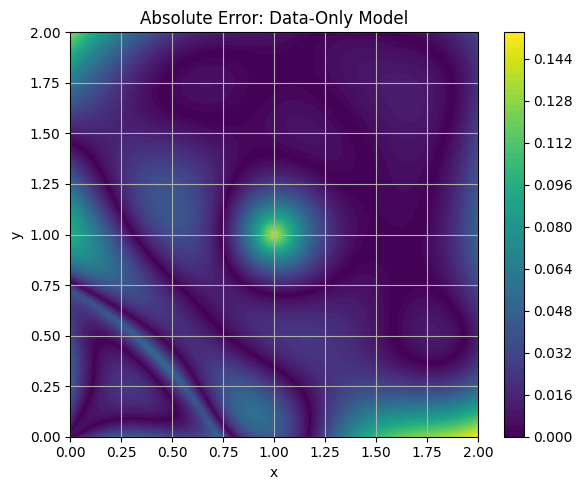

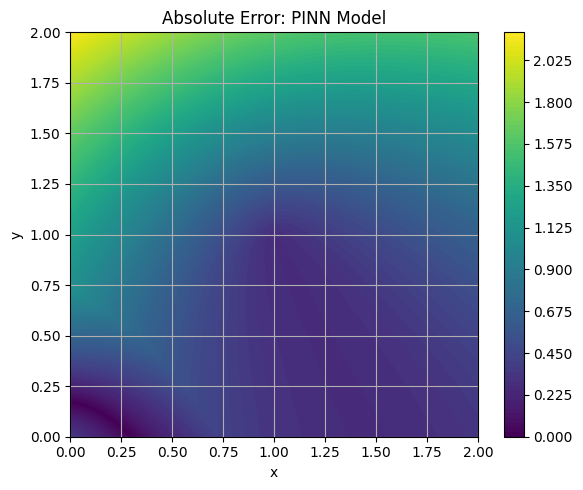

RMSE - Data-Only Model: 0.028757
RMSE - PINN Model: 0.903026


In [10]:
# Error plots
error_data = np.abs(T_data_pred - T_true)
error_pinn = np.abs(T_pinn_pred - T_true)

plot_comparison(T_true, error_data, "Absolute Error: Data-Only Model")
plot_comparison(T_true, error_pinn, "Absolute Error: PINN Model")

# Optional: RMSE scores
rmse_data = np.sqrt(np.mean(error_data**2))
rmse_pinn = np.sqrt(np.mean(error_pinn**2))
print(f"RMSE - Data-Only Model: {rmse_data:.6f}")
print(f"RMSE - PINN Model: {rmse_pinn:.6f}")


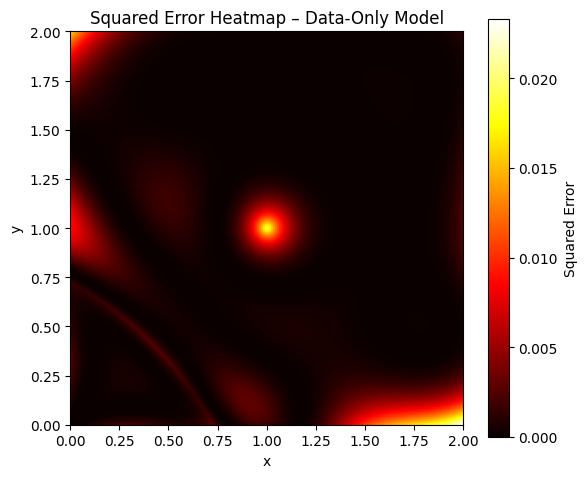

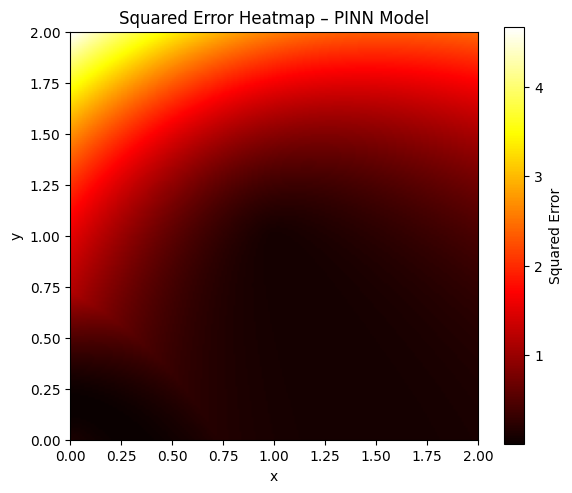

In [25]:
def plot_heatmap(error_grid, title):
    plt.figure(figsize=(6, 5))
    plt.imshow(error_grid, origin='lower', extent=[0, 2, 0, 2], cmap='hot')
    plt.colorbar(label='Squared Error')
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# Plot squared error heatmaps
plot_heatmap(squared_error_data, "Squared Error Heatmap – Data-Only Model")
plot_heatmap(squared_error_pinn, "Squared Error Heatmap – PINN Model")


## QUESTION 2

In [11]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Generate data
X, y = make_moons(n_samples=1000, noise=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


In [12]:
# Simple 1-hidden-layer NN
class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 2)  # Output logits for 2 classes
        )

    def forward(self, x):
        return self.layers(x)

# Instantiate model, loss, and optimizer
model_fc = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_fc.parameters(), lr=0.01)

# Training loop
epochs = 200
for epoch in range(epochs):
    model_fc.train()
    optimizer.zero_grad()
    outputs = model_fc(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 0.6691
Epoch 50, Loss: 0.2172
Epoch 100, Loss: 0.1474
Epoch 150, Loss: 0.1099


In [13]:
# Prediction and accuracy
model_fc.eval()
with torch.no_grad():
    pred_train = model_fc(X_train_tensor).argmax(dim=1)
    pred_test = model_fc(X_test_tensor).argmax(dim=1)

train_acc = (pred_train == y_train_tensor).float().mean().item()
test_acc = (pred_test == y_test_tensor).float().mean().item()

print(f"Train Accuracy: {train_acc:.2%}")
print(f"Test Accuracy: {test_acc:.2%}")


Train Accuracy: 96.75%
Test Accuracy: 95.50%


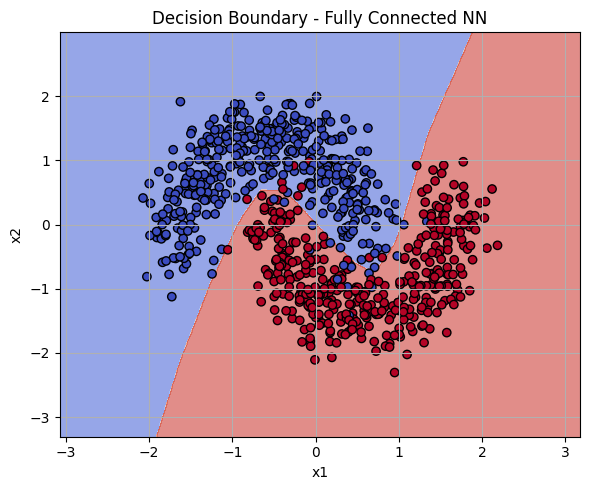

In [14]:
import numpy as np

def plot_decision_boundary(model, X, y, title):
    # Create a meshgrid
    h = 0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Flatten and convert to tensor
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    # Predict
    model.eval()
    with torch.no_grad():
        Z = model(grid_tensor).argmax(dim=1).numpy()

    # Reshape and plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(6, 5))
    plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.6)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k')
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot decision boundary for train set
plot_decision_boundary(model_fc, X_train, y_train, "Decision Boundary - Fully Connected NN")


## Part B: replacing the hidden layer with a Neural ODE block.



In [15]:
!pip install torchdiffeq


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 959.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

#Define the ODE Function and Neural ODE Block

In [16]:
from torchdiffeq import odeint

# Define the function f(h, t)
class ODEFunc(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16),
            nn.Tanh(),
            nn.Linear(16, 2)
        )

    def forward(self, t, h):
        return self.net(h)


# Build the Neural ODE Model

In [17]:
class NeuralODEClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.odefunc = ODEFunc()
        self.t0 = torch.tensor([0.0, 1.0])  # integrate from t=0 to t=1
        self.classifier = nn.Linear(2, 2)  # map final ODE output to logits

    def forward(self, x):
        h = odeint(self.odefunc, x, self.t0, method='rk4')  # shape: [2, batch, features]
        h_final = h[-1]  # take value at t=1
        return self.classifier(h_final)


# Train Neural ODE Classifier

In [18]:
model_ode = NeuralODEClassifier()
optimizer_ode = torch.optim.Adam(model_ode.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Training loop
epochs = 200
for epoch in range(epochs):
    model_ode.train()
    optimizer_ode.zero_grad()
    outputs = model_ode(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer_ode.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 1.0141
Epoch 50, Loss: 0.2660
Epoch 100, Loss: 0.2601
Epoch 150, Loss: 0.2535


In [19]:
# Accuracy check
model_ode.eval()
with torch.no_grad():
    pred_train_ode = model_ode(X_train_tensor).argmax(dim=1)
    pred_test_ode = model_ode(X_test_tensor).argmax(dim=1)

train_acc_ode = (pred_train_ode == y_train_tensor).float().mean().item()
test_acc_ode = (pred_test_ode == y_test_tensor).float().mean().item()

print(f"Train Accuracy (ODE): {train_acc_ode:.2%}")
print(f"Test Accuracy (ODE): {test_acc_ode:.2%}")


Train Accuracy (ODE): 89.50%
Test Accuracy (ODE): 82.00%


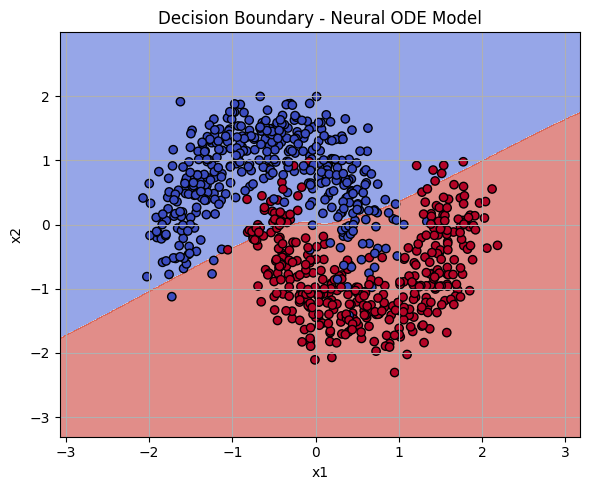

In [20]:
plot_decision_boundary(model_ode, X_train, y_train, "Decision Boundary - Neural ODE Model")


## PART C

In [21]:
print(f"FC Model - Train Accuracy: {train_acc:.2%}, Test Accuracy: {test_acc:.2%}")
print(f"ODE Model - Train Accuracy: {train_acc_ode:.2%}, Test Accuracy: {test_acc_ode:.2%}")


FC Model - Train Accuracy: 96.75%, Test Accuracy: 95.50%
ODE Model - Train Accuracy: 89.50%, Test Accuracy: 82.00%
